In [1]:
# If this cell does not work try running `pip install nbformat`

import io
from IPython import nbformat

nb = nbformat.read("Lab1-2021.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 237


D:\anaconda\lib\site-packages\IPython\nbformat.py:12: ShimWarning: The `IPython.nbformat` package has been deprecated since IPython 4.0. You should import from nbformat instead.
  warn("The `IPython.nbformat` package has been deprecated since IPython 4.0. "


# CS4035 - Cyber Data Analytics
## Lab 1 - Fraud data

## Group Number : 29

## Student 1 
### Name : Mingyu Gao
### ID : 5216281

## Student 2
### Name : Yuhang Tian
### ID : 5219728

## Readme

## Load Library

In [2]:
import numpy as np 
import pandas as pd

import random

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, roc_auc_score, plot_confusion_matrix, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

from jupyterthemes import jtplot
jtplot.style('grade3')

## Read Data

In [3]:
df = pd.read_csv('./data_for_student_case.csv')
df.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
0,1,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798
1,2,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595
2,3,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142
3,4,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744
4,5,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271


In [4]:
type_name, type_count = np.unique(df['simple_journal'], return_counts=True)
for i in range(len(type_name)):
    print(str(type_name[i])+':', type_count[i], '('+str(100*np.round(type_count[i]/len(df),4))+'%)')

Chargeback: 345 (0.12%)
Refused: 53346 (18.37%)
Settled: 236691 (81.51%)


## Data Preporcessing

### Delete Refused Catagory

In [5]:
df_new = df[df['simple_journal'] != 'Refused'].copy()
type_name, type_count = np.unique(df_new['simple_journal'], return_counts=True)
for i in range(len(type_name)):
    print(str(type_name[i])+':', type_count[i], '('+str(100*np.round(type_count[i]/len(df_new),4))+'%)')

Chargeback: 345 (0.15%)
Settled: 236691 (99.85000000000001%)


### Data Encoding

In [6]:
# 1.label
df_new['label'] = df['simple_journal'].apply(lambda x: 1 if x == 'Chargeback' else 0)

# 2.creationdate
df_new['creationdate'] = pd.to_datetime(df_new['creationdate'])
df_new['creationdate'] = df_new['creationdate'].dt.date
date_enc = LabelEncoder()
date_enc.fit(df_new['creationdate'])
df_new['date'] = date_enc.transform(df_new['creationdate'])

# 3.converting different currency to a homogeneous value
to_euro = {
    'AUD': 0.64147,
    'GBP': 1.1494,
    'MXN': 0.04169,
    'NZD': 0.59499,
    'SEK': 0.09859
}
def amount_to_euro(df_colums):
    amount, currency = df_colums
    return to_euro[currency] * amount / 100
df_new['euroAmount'] = df_new[['amount', 'currencycode']].apply(amount_to_euro, axis=1)

# 4. aggregation for cvcresponse code
df_new['cvcRes'] = df_new['cvcresponsecode'].apply(lambda x: 3 if (x >= 3 and x<6) else x)

# encoding for other features
column_list = df_new.columns.values.tolist()
col_ori = ['txvariantcode','issuercountrycode','accountcode', 'shopperinteraction', 
           'shoppercountrycode', 'card_id', 'ip_id', 'mail_id']
col_new = ['txCode','issuerCountry', 'account', 'interaction',
           'shopperCountry', 'card_id', 'ip_id', 'mail_id']
label_encoder = LabelEncoder()
for col in range(0,len(col_ori)): 
    df_new[col_new[col]] = label_encoder.fit_transform(df_new[col_ori[col]].astype(str))

## Visualization task

In [7]:
df_fraud = df_new[df_new['label'] == 1]
df_benign = df_new[df_new['label'] == 0]

### Plot visulations 

#### Boxplot - Amount

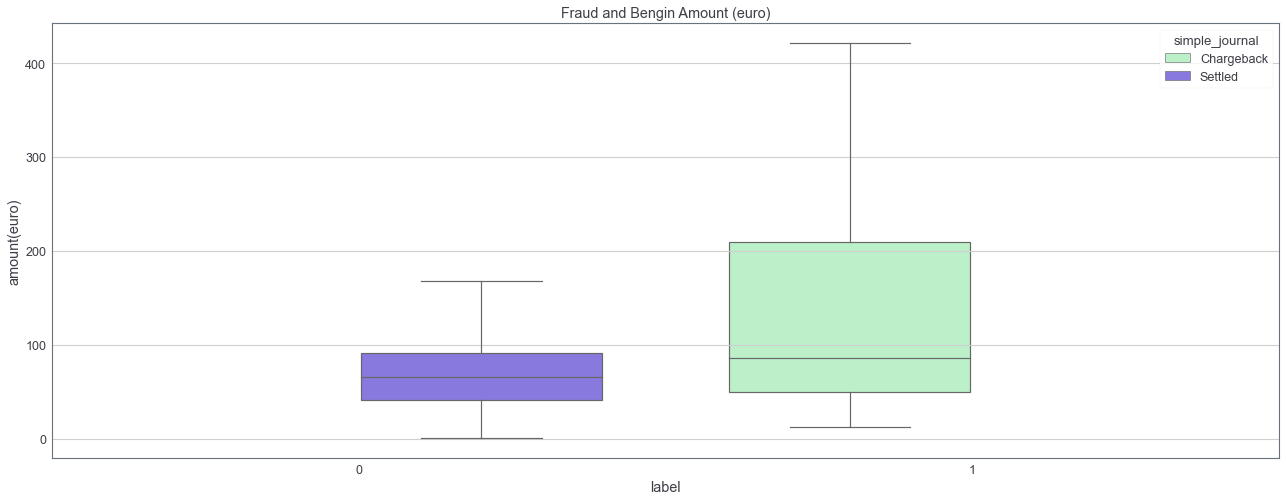

In [8]:
colors = ['#B3F9C5', '#7b68ee']
figure, (ax) = plt.subplots(1, figsize=(22,8))
ax = sns.boxplot(x='label', y='euroAmount', hue='simple_journal', data=df_new, 
                 showfliers=False, palette=colors
                 )
ax.set(xlabel='label', ylabel='amount(euro)')
plt.title('Fraud and Bengin Amount (euro)')
plt.savefig('./figures/amountBoxplot.pdf', dpi=1200)
plt.show()

#### Histogram - txCode/issuerCountry/account/cvcRes

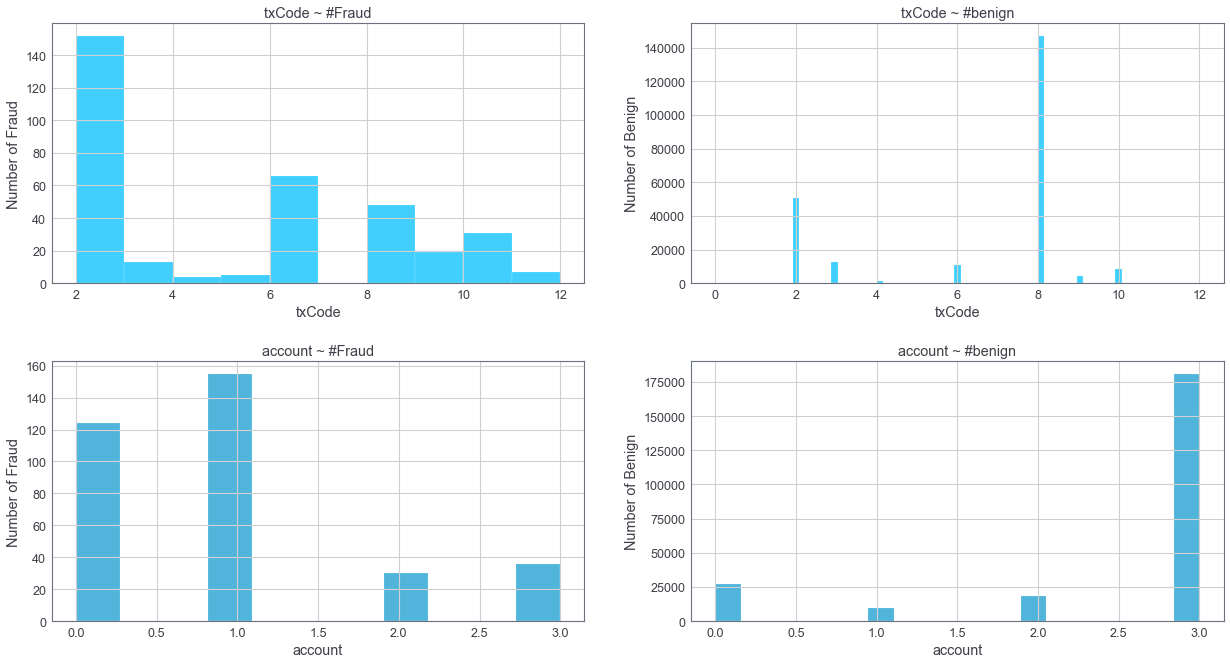

In [9]:
plt.figure(figsize=(21,11))
plt.subplots_adjust(wspace=0.2,hspace=0.3)

plt.subplot(221)
sns.histplot(x='txCode', data=df_fraud, color='#00bfff')
plt.ylabel('Number of Fraud')
plt.title('txCode ~ #Fraud')
plt.subplot(222)
sns.histplot(x='txCode', data=df_benign, color='#00bfff')
plt.ylabel('Number of Benign')
plt.title('txCode ~ #benign')

plt.subplot(223)
sns.histplot(x='account', data=df_fraud, color='#179ccf')
plt.ylabel('Number of Fraud')
plt.title('account ~ #Fraud')
plt.subplot(224)
sns.histplot(x='account', data=df_benign, color='#179ccf')
plt.ylabel('Number of Benign')
plt.title('account ~ #benign')

plt.savefig('./figures/txCode_account.pdf', dpi=1200)
plt.show()

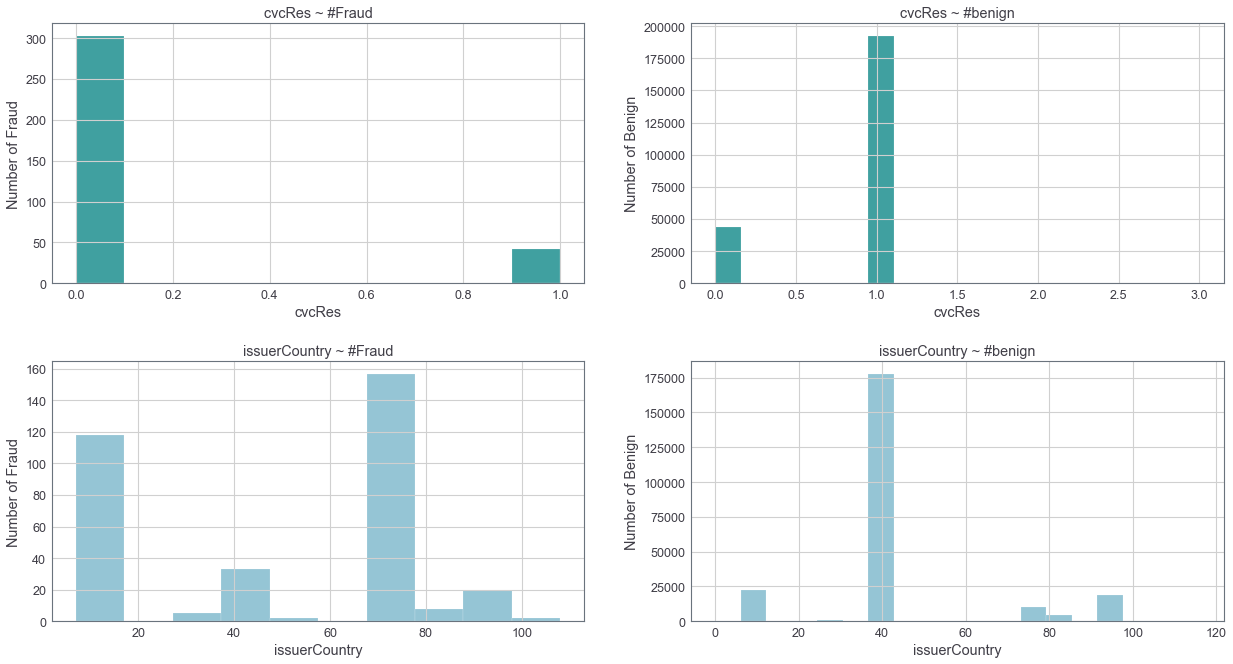

In [10]:
plt.figure(figsize=(21,11))
plt.subplots_adjust(wspace=0.2,hspace=0.3)

plt.subplot(221)
sns.histplot(x='cvcRes', data=df_fraud, color='#008080')
plt.ylabel('Number of Fraud')
plt.title('cvcRes ~ #Fraud')
plt.subplot(222)
sns.histplot(x='cvcRes', data=df_benign, color='#008080')
plt.ylabel('Number of Benign')
plt.title('cvcRes ~ #benign')

plt.subplot(223)
sns.histplot(x='issuerCountry', data=df_fraud, color='#72b2c7')
plt.ylabel('Number of Fraud')
plt.title('issuerCountry ~ #Fraud')
plt.subplot(224)
sns.histplot(x='issuerCountry', data=df_benign, color='#72b2c7')
plt.ylabel('Number of Benign')
plt.title('issuerCountry ~ #benign')

plt.savefig('./figures/cvcRes_issuerCountry.pdf', dpi=1200)
plt.show()

#### Describe the visualizations and provide relavant explanations of features and relations.

## Imbalance task

In [11]:
df_smote = df_new.copy()

In [12]:
df_smote = df_smote.drop(['txid', 'txvariantcode', 'cvcresponsecode',
 'bookingdate', 'issuercountrycode','amount', 'shopperinteraction',
 'simple_journal','creationdate', 'accountcode','currencycode'], axis ='columns')

In [13]:
column_list = [
 'bin',
 'shoppercountrycode',
 'cardverificationcodesupplied',
 'mail_id',
 'ip_id',
 'card_id',
 'date']
for col in column_list:
    df_smote[col] = label_encoder.fit_transform(df_smote[col].astype(str))

In [14]:
df_smote.head()

,bin,shoppercountrycode,cardverificationcodesupplied,mail_id,ip_id,card_id,label,date,euroAmount,cvcRes,txCode,issuerCountry,account,interaction,shopperCountry
0,1998,98,1,97450,177775,181254,1,0,27.01512,0,2,76,1,1,98
1,2364,98,1,190289,104569,149455,1,1,18.71881,0,2,76,1,1,98
2,1965,98,1,21433,99619,25340,1,1,62.49331,0,2,76,1,1,98
3,2374,98,1,81738,187420,178315,1,35,45.81731,0,2,76,1,1,98
4,1301,98,1,176120,106944,120538,1,90,37.47931,0,6,76,1,1,98


In [15]:
df_smote_label = df_smote['label'].copy() # all labels
df_smote_temp = df_smote.copy()
df_smote_feature = df_smote_temp.drop(['label'], axis ='columns') # all features

In [16]:
# split train_set and test_set after extracting features and labels
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df_smote_temp, test_size=0.2, random_state=42 )
x_train_set, x_test_set, y_train_set, y_test_set = train_test_split(df_smote_feature, df_smote_label, test_size=0.2, random_state=42)
print("Number of rows in train_set " + str(len(train_set)))
print("Number of rows in test_set " + str(len(test_set)))
print("Number of rows in x_train_set " + str(len(x_train_set)))
print("Number of rows in x_test_set " + str(len(x_test_set)))

Number of rows in train_set 189628
Number of rows in test_set 47408
Number of rows in x_train_set 189628
Number of rows in x_test_set 47408


In [17]:
# select fraud cases
df_smote.head()
# split fraud date for smoting
fraud_data = train_set.loc[df_smote['label'] == 1]
benign_data = train_set.loc[df_smote['label'] == 0]
print("Number of rows in trainset_fraud_data " + str(len(fraud_data)))
print("Number of rows in testset_benign_data " + str(len(benign_data)))

Number of rows in trainset_fraud_data 270
Number of rows in testset_benign_data 189358


In [18]:
fraud_data = fraud_data.drop(['label'], axis ='columns')

### Print ROC curves

In [19]:
# function for drawing ROC
from sklearn.metrics import roc_curve, roc_auc_score
def return_roc(model, x_train, y_train, x_test, y_test, normalize=True):
# #     if (normalize):
#     scaler_norm = Normalizer().fit(x_train)
#     x_train = scaler_norm.transform(x_train)
#     x_test = scaler_norm.transform(x_test)
    
    model.fit(x_train, y_train)
    probs = model.predict_proba(x_test)[:, 1]
    auc = roc_auc_score(y_test, probs)
    fpr, tpr, _ = roc_curve(y_test, probs)    
    
    return fpr, tpr, auc

In [20]:
# building smote
from sklearn.neighbors import NearestNeighbors
import random
def smote(minority_for_smoting, k):
# k - sampling rate
    # T - Number of minority class samples
    T = len(minority_for_smoting)
    # cols - Column number of minority class samples
    n_features = len(minority_for_smoting.columns)
    # find the nearest k + 1 neighbours
    # number of neighbours > sampling rate
    nbrs = NearestNeighbors(n_neighbors = k+1, algorithm = 'auto').fit(minority_for_smoting)
    # distance : Array representing the lengths to points
    # indices: Indices of the nearest points in the population matrix
    distances, indices = nbrs.kneighbors(minority_for_smoting)
    nnarray = []
    data_array = [i for i in range(0,T * k)]
    # generating a matric for storing synthetic samples
    synthetic = pd.DataFrame(np.nan, index = data_array, columns = minority_for_smoting.columns)
    n = 0
    for i in range(len(indices)):
        # nnarray: storing the k+1 nearest neighbours
        for index in indices[i]:
            if index != i:
                nnarray.append(index)
        # choose a neighbour from the nearest k neighbours
        for k in nnarray:
            for m in range(0,n_features):
                # calculating the difference between the sample[k] to its neighbour [i]
                diff = np.subtract(minority_for_smoting.iloc[k, m], minority_for_smoting.iloc[i, m], dtype = np.float32)               
                # generating a new sample
                gap = random.uniform(0,1)
                synthetic.iloc[n, m] = minority_for_smoting.iloc[i, m] + (gap * diff)
            n += 1
        nnarray = []   
    smoted_data = minority_for_smoting.append(synthetic, ignore_index = True)    
    return smoted_data

In [21]:
# implement smote by ourselves
smoted_fraud = smote(fraud_data,5)
print(str(len(smoted_fraud))) # check the new fraud cases

1620


In [22]:
smoted_fraud["label"] = np.ones(len(smoted_fraud)) # add labels for the smoted ones
smoted_fraud.head() 

,bin,shoppercountrycode,cardverificationcodesupplied,mail_id,ip_id,card_id,date,euroAmount,cvcRes,txCode,issuerCountry,account,interaction,shopperCountry,label
0,1965.0,98.0,1.0,137758.0,95600.0,44842.0,3.0,83.33831,0.0,2.0,76.0,1.0,1.0,98.0,1.0
1,1052.0,8.0,1.0,43932.0,98051.0,32184.0,14.0,246.96595,0.0,10.0,7.0,0.0,1.0,8.0,1.0
2,2032.0,8.0,1.0,59789.0,138965.0,38182.0,59.0,218.09980,0.0,2.0,7.0,0.0,1.0,8.0,1.0
3,1504.0,8.0,1.0,22478.0,90256.0,138773.0,82.0,279.03945,0.0,6.0,7.0,0.0,1.0,8.0,1.0
4,940.0,47.0,1.0,132251.0,1434.0,143579.0,19.0,36.72333,1.0,8.0,40.0,3.0,1.0,47.0,1.0


In [23]:
# merge smoted fraud cases and benign cases
frames = [smoted_fraud, benign_data]
smoted_trainset = pd.concat(frames, sort=False)
print("length of merged: " + str(len(smoted_trainset)))

length of merged: 190978


In [24]:
# select labels and features
smoted_labels = smoted_trainset['label'].copy()
smoted_features = smoted_trainset.drop(['label'], axis ='columns')


In [25]:
print(str(len(smoted_features)))

190978


In [26]:
# # implement smote
# from imblearn.over_sampling import SMOTE
# def smote(X,y):
#     sm = SMOTE(random_state=42)
#     X_res, y_res = sm.fit_resample(X, y)
#     return X_res, y_res

In [27]:
# smoted train set (including benign and fraud)
# smoted_features, smoted_labels = smote(x_train_set, y_train_set)

### classifier

In [28]:
# 1. Random Forest
from sklearn.ensemble import RandomForestClassifier
clf1 = RandomForestClassifier(n_estimators= 200, max_depth=10) 

In [ ]:
plt.figure(figsize = (16,9))
unsmoted_fpr, unsmoted_tpr, unsmoted_auc = return_roc(clf1, x_train_set, y_train_set, x_test_set, y_test_set)
plt.plot(unsmoted_fpr, unsmoted_tpr,"-.", label='Unsmoted', linewidth=2)
smoted_fpr, smoted_tpr, smoted_auc = return_roc(clf1, smoted_features, smoted_labels, x_test_set, y_test_set)
plt.plot(smoted_fpr, smoted_tpr,"--", label='Smoted', linewidth=2)
print("Unsmoted AUC =", unsmoted_auc, "Smoted AUC =", smoted_auc)
plt.legend(['Unsmoted', 'Smoted'])
plt.title("Random Forest")
plt.show()

In [ ]:
from sklearn.metrics import plot_confusion_matrix
clf1.fit(smoted_features, smoted_labels)
plot_confusion_matrix(clf1, x_test_set, y_test_set)
plt.show()

In [ ]:
# 2. Naive Bayes
from sklearn.naive_bayes import GaussianNB
clf2 = GaussianNB()

In [ ]:
plt.figure(figsize = (16,9))
unsmoted_fpr, unsmoted_tpr, unsmoted_auc = return_roc(clf2, x_train_set, y_train_set, x_test_set, y_test_set)
plt.plot(unsmoted_fpr, unsmoted_tpr,"-.", label='Unsmoted', linewidth=2)
smoted_fpr, smoted_tpr, smoted_auc = return_roc(clf2, smoted_features, smoted_labels, x_test_set, y_test_set)
plt.plot(smoted_fpr, smoted_tpr,"--", label='Smoted', linewidth=2)
print("Unsmoted AUC =", unsmoted_auc, "Smoted AUC =", smoted_auc)
plt.legend(['Unsmoted', 'Smoted'])
plt.title("Naive Bayes")
plt.show()

In [ ]:
from sklearn.metrics import plot_confusion_matrix
clf2.fit(smoted_features, smoted_labels)
plot_confusion_matrix(clf2, x_test_set, y_test_set)
plt.show()

In [ ]:
# 3. Decision Tree
from sklearn import tree
clf3 = tree.DecisionTreeClassifier(splitter='random', max_depth = 10)

In [ ]:
plt.figure(figsize = (16,9))
unsmoted_fpr, unsmoted_tpr, unsmoted_auc = return_roc(clf3, x_train_set, y_train_set, x_test_set, y_test_set)
plt.plot(unsmoted_fpr, unsmoted_tpr,"-.", label='Unsmoted', linewidth=2)
smoted_fpr, smoted_tpr, smoted_auc = return_roc(clf3, smoted_features, smoted_labels, x_test_set, y_test_set)
plt.plot(smoted_fpr, smoted_tpr,"--", label='Smoted', linewidth=2)
print("Unsmoted AUC =", unsmoted_auc, "Smoted AUC =", smoted_auc)
plt.legend(['Unsmoted', 'Smoted'])
plt.title("Decision Tree")
plt.show()

In [ ]:
from sklearn.metrics import plot_confusion_matrix
clf2.fit(smoted_features, smoted_labels)
plot_confusion_matrix(clf2, x_test_set, y_test_set)
plt.show()

In [ ]:
# draw three curves in one plot
plt.figure(figsize = (16,9))
smoted_fpr1, smoted_tpr1, smoted_auc1 = return_roc(clf1, smoted_features, smoted_labels, x_test_set, y_test_set)
plt.plot(smoted_fpr1, smoted_tpr1,"--", label='Random Forest', linewidth=2)

smoted_fpr2, smoted_tpr2, smoted_auc2 = return_roc(clf2, smoted_features, smoted_labels, x_test_set, y_test_set)
plt.plot(smoted_fpr, smoted_tpr,"-.", label='Naive Bayes', linewidth=2)

smoted_fpr3, smoted_tpr3, smoted_auc3 = return_roc(clf2, smoted_features, smoted_labels, x_test_set, y_test_set)
plt.plot(smoted_fpr3, smoted_tpr3,".-", label='Decision Tree', linewidth=2)
plt.legend(['Random Forest', 'Naive Bayes', 'Decision Tree'])
plt.title("Three classifiers for smoted data")
plt.show()

### Analyse the performance of the classifiers. Explain which method performs best.

### Is using SMOTE a good idea? Why (not)?

## Privacy task

### Print ROC curves

#### Useful Columns Extraction

In [ ]:
df_trial = df_new[[
    'date', 'issuerCountry', 
    'shopperCountry', 'interaction', 'euroAmount', 'cardverificationcodesupplied', 'cvcRes', 
    'mail_id', 'ip_id', 'card_id', 'bin','txCode', 'account', 'label'
    ]].copy()

#### NAN Modification

In [ ]:
df_trial.loc[df_trial['cardverificationcodesupplied'].isna(),'cardverificationcodesupplied'] = False
df_trial.loc[df_trial['issuerCountry'].isna(),'issuerCountry'] = 'ZZ'
df_trial.loc[df_trial['shopperCountry'].isna(),'shopperCountry'] = 'ZZ'

print(np.where(df_trial.isna())[1]) #no NAN anymore

#### Data Spliting

In [ ]:
df_label = df_trial['label']
df_sample = df_trial[[
    'date', 'issuerCountry', 
    'shopperCountry', 'interaction', 'euroAmount', 'cardverificationcodesupplied', 'cvcRes', 
    'mail_id', 'ip_id', 'card_id', 'bin','txCode', 'account'
    ]]

x_train, x_test, y_train, y_test = train_test_split(df_sample, df_label, test_size=0.20, shuffle=True, random_state=42)

#### Resample

In [ ]:
def smote(X,y):
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X, y)
    return X_res, y_res

In [ ]:
x_train_unswapped, y_train_unswapped = smote(x_train, y_train)
print("After SMOTE:", np.unique(y_train_unswapped, return_counts=True))

#### Rank Swapping
The rank swapping alogrithm will be applied to:
- bin: card issuer identifier
- mail_id: Email address
- ip_id: Ip address
- card_id: Card number

##### Implement the rank swapping algorithm.

In [ ]:
def rank_swapping(df, columns, p=1):
    '''
    df: pandas dataframe
    columns: the string names of columns
    p: the swapping range p%
    replace: replace the original dataframe
    
    return: rank swapped dataframe 
    '''
    if p == 0:
        return df
    
    print("It will take "+str(p)+" neighbour(s) into consideration")
    print(str(columns) + " - Swapping Range:", str(np.round(100*p/len(df),4))+'%')
    
    df_ = df.copy()
    length = len(df_)
    
    for column in columns:
        df_.sort_values(by=column, inplace=True)
        df_.reset_index(drop=True, inplace=True)
        col_values = df_[column].copy()
        for current_index in range(0, length):
            swap_index = current_index + random.randint(-p,p)
            if swap_index > length - 1:
                swap_index = random.randint(current_index, length-1)
            elif swap_index < 0:
                swap_index = random.randint(0, current_index)
            df_.at[current_index, column], df_.at[swap_index, column] = col_values[swap_index], col_values[current_index]
            
    return df_

##### Apply rank swapping algorithm

In [ ]:
x_train_unswapped.head()

In [ ]:
x_train_swapped, y_train_swapped = x_train_unswapped.copy(), y_train_unswapped.copy()
x_train_swapped['temp_label'] = y_train_swapped.copy()
x_train_swapped = rank_swapping(x_train_swapped, ['bin', 'mail_id', 'ip_id', 'card_id'], p=100)
y_train_swapped = x_train_swapped['temp_label'].copy()
x_train_swapped.drop(columns=['temp_label'], inplace=True)

In [ ]:
x_train_unswapped.head()

In [ ]:
x_train_swapped.head()

##### Train three classifiers using rank swapping/unswapping

In [ ]:
def return_roc(model, x_train, y_train, x_test, y_test, normalize=True):
    if (normalize):
        scaler_norm = Normalizer().fit(x_train)
        x_train = scaler_norm.transform(x_train)
        x_test = scaler_norm.transform(x_test)
    
    model.fit(x_train, y_train)
    probs = model.predict_proba(x_test)[:, 1]
    auc = roc_auc_score(y_test, probs)
    fpr, tpr, _ = roc_curve(y_test, probs)    
    
    return fpr, tpr, auc

###### Decision Tree

In [ ]:
dt = DecisionTreeClassifier(splitter='random', max_depth=10)
plt.figure(figsize=(16,9))
unswapped_fpr, unswapped_tpr, unswapped_auc = return_roc(dt, x_train_unswapped, y_train_unswapped, x_test, y_test)
plt.plot(unswapped_fpr, unswapped_tpr, "-D", label='Unswapped', linewidth=2)
swapped_fpr, swapped_tpr, swapped_auc = return_roc(dt, x_train_swapped, y_train_swapped, x_test, y_test)
plt.plot(swapped_fpr, swapped_tpr, "-X", label='Swapped', linewidth=2)
print("Unswapped AUC =", unswapped_auc, "Swapped AUC =", swapped_auc)
plt.xlabel('Flase Positive')
plt.ylabel('True Positive')
plt.legend(['Unswapped', 'Swapped'])
plt.title("Decision Tree")
plt.show()

In [ ]:
dt.fit(x_train_unswapped, y_train_unswapped)
plot_confusion_matrix(dt, x_test, y_test)
plt.title('confusion matrix')
plt.show()

###### Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=200, max_depth=3)
plt.figure(figsize=(16,9))
unswapped_fpr, unswapped_tpr, unswapped_auc = return_roc(rf, x_train_unswapped, y_train_unswapped, x_test, y_test, normalize=False)
plt.plot(unswapped_fpr, unswapped_tpr, "-D", label='Unswapped', linewidth=2)
swapped_fpr, swapped_tpr, swapped_auc = return_roc(rf, x_train_swapped, y_train_swapped, x_test, y_test, normalize=False)
plt.plot(swapped_fpr, swapped_tpr, "-X", label='Swapped', linewidth=2)
print("Unswapped AUC =", unswapped_auc, "Swapped AUC =", swapped_auc)
plt.xlabel('Flase Positive')
plt.ylabel('True Positive')
plt.legend(['Unswapped', 'Swapped'])
plt.title("Random Forest")
plt.show()

In [ ]:
rf.fit(x_train_unswapped, y_train_unswapped)
plot_confusion_matrix(rf, x_test, y_test)
plt.title('confusion matrix')
plt.show()

######  GaussianNB

In [ ]:
nb = GaussianNB()
plt.figure(figsize=(16,9))
unswapped_fpr, unswapped_tpr, unswapped_auc = return_roc(nb, x_train_unswapped, y_train_unswapped, x_test, y_test)
plt.plot(unswapped_fpr, unswapped_tpr, "-D", label='Unswapped', linewidth=2)
swapped_fpr, swapped_tpr, swapped_auc = return_roc(nb, x_train_swapped, y_train_swapped, x_test, y_test)
plt.plot(swapped_fpr, swapped_tpr, "-X", label='Swapped', linewidth=2)
print("Unswapped AUC =", unswapped_auc, "Swapped AUC =", swapped_auc)
plt.xlabel('Flase Positive')
plt.ylabel('True Positive')
plt.legend(['Unswapped', 'Swapped'])
plt.title("GaussianNB")
plt.show()

In [ ]:
nb.fit(x_train_unswapped, y_train_unswapped)
plot_confusion_matrix(nb, x_test, y_test)
plt.title('confusion matrix')
plt.show()

### Analyse the performance of the classifiers. Explain which method performs best.

### Can you explain the performance difference for the different classifiers? Is it advisable to protect people’s privacy using rank-swapping? Why (not)?

## Classification task

### Print relevant plots and metrics with clear headings.

In [ ]:
def k_fold_validation(X, y, model, scoring='precision', k_flod=10):
    cv = KFold(n_splits=k_flod, random_state=42, shuffle=True)
    scores = cross_validate(model, X, y, scoring=scoring, return_estimator=True, cv=cv, n_jobs=-1)
    max_score_index = np.argmax(scores['test_score'])
    
    return scores['test_score'][max_score_index], scores['estimator'][max_score_index] 

#### White Box - Decision Tree

In [ ]:
dt = DecisionTreeClassifier(splitter='random', max_depth=10)
dt_max_score, dt_estimator = k_fold_validation(X = x_train_unswapped, y = y_train_unswapped, model=dt)

In [ ]:
plot_confusion_matrix(dt_estimator, x_test, y_test)
plt.show()

#### Black-box: Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=200, max_depth=5)
rf_max_score, rf_estimator = k_fold_validation(X = x_train_unswapped, y = y_train_unswapped, model=rf)

In [ ]:
plt.figure(figsize=(16,9))
plot_confusion_matrix(rf_estimator, x_test, y_test)
plt.show()

### Explain the applied data pre-processing steps, learning algorithms, and post-processing steps or ensemble methods. Compare the performance of the two algorithms, focusing on performance criteria that are relevant in practice, use 10-fold cross-validation.

## Bonus task

### Provide code and report below